In [1]:
import numpy as np
from scipy.stats import lognorm, uniform
import matplotlib.pyplot as plt
from scipy import integrate

In [2]:
# 8个bidder, auction次数1w次, 每个人的value来自于5-50的均匀分布， 初始ctr来自于分布U(0.005, 0.5)，优惠券的价格分别为0， 2， 4， 8
# 0 为 1倍 ctr，2为1.1倍ctr, 4为1.2倍ctr, 8为1.3倍ctr
# 假设只有ctr，没有cvr的设定

ctr_boost = np.array([1, 1.1, 1.2, 1.3])
# cvr_boost = np.array([1, 1.1, 1.2, 1.3])
voucher = np.array([0, 2, 4, 8])
ctrs = np.random.uniform(0.005, 0.5, (50, 8))
# cvrs = np.random.uniform(0.005, 0.5, (50, 8))
valuations = np.random.uniform(5, 50, (50, 8))


array([ 0.05  ,  0.0308,  0.0024, -0.0702])

In [11]:
np.argmax(0.01 * ctr_boost * (5 - cvr_boost * voucher))

0

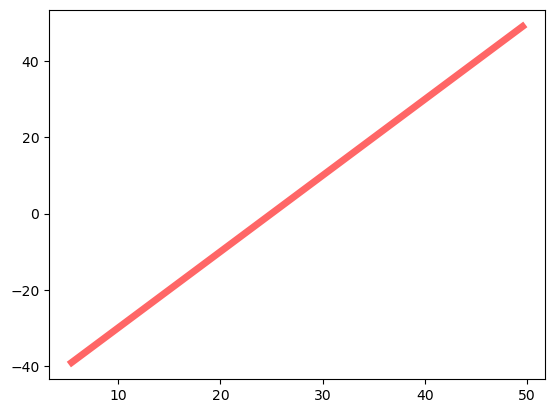

In [2]:
x = np.linspace(uniform.ppf(0.01, loc = 5, scale=45), uniform.ppf(0.99, loc = 5, scale = 45), 1000)
def virtual_value(v):
    return v - ((1 - uniform.cdf(v, loc = 5, scale = 45)) / uniform.pdf(v, loc = 5, scale = 45))
y = virtual_value(x)
fig, ax = plt.subplots(1, 1)
ax.plot(x, y, 'r-', lw = 5, alpha = 0.6)

In [18]:
x

array([ 5.45,  6.35,  7.25,  8.15,  9.05,  9.95, 10.85, 11.75, 12.65,
       13.55, 14.45, 15.35, 16.25, 17.15, 18.05, 18.95, 19.85, 20.75,
       21.65, 22.55, 23.45, 24.35, 25.25, 26.15, 27.05, 27.95, 28.85,
       29.75, 30.65, 31.55, 32.45, 33.35, 34.25, 35.15, 36.05, 36.95,
       37.85, 38.75, 39.65, 40.55, 41.45, 42.35, 43.25, 44.15, 45.05,
       45.95, 46.85, 47.75, 48.65, 49.55])

In [3]:
def find_index(value_list, k):
    l, r = 0, len(value_list) - 1
    while(l < r):
        mid = (l + r + 1) // 2
        if value_list[mid] > k:
            r = mid - 1
        else:
            l = mid
    return l

In [8]:
virtual_value_list = virtual_value(x)

In [4]:
# 这里考虑的是均匀分布

def allocation_rule(ctr, cvr):
    allocations = []
    generalized_virtual = []
    for i in x:
        best_voucher_arg = np.argmax(ctr * ctr_boost * (virtual_value(i) - cvr_boost * cvr * voucher))
        best_voucher = voucher[best_voucher_arg]
        generalized_virtual.append(np.max(ctr * ctr_boost * (virtual_value(i) - cvr_boost * cvr * voucher)))
        if virtual_value(i) < 0:
            allocations.append(0)
        else:
            allocations.append(ctr * ctr_boost[best_voucher_arg])
    return allocations

def simulate_an_auction(n):
   '''
      n bidders
   '''
   ctrs = np.random.uniform(0.005, 0.5, (n, ))
   cvrs = np.random.uniform(0.005, 0.5, (n, ))
   valuations = np.random.uniform(5, 50, (n, ))
   rank_score = np.zeros((n, ))
   best_vouchers = np.zeros((n, ), dtype=np.int32)
   allocations_all = []
   for i in range(n):
      allocations_all.append(allocation_rule(ctrs[i], cvrs[i]))
      best_voucher_arg = np.argmax(ctrs[i] * ctr_boost * (virtual_value(valuations[i]) - cvr_boost * cvrs[i] * voucher))
      best_vouchers[i] = best_voucher_arg
      rank_score[i] = np.max(ctrs[i] * ctr_boost * (virtual_value(valuations[i]) - cvr_boost * cvrs[i] * voucher))
   re_rank = np.argsort(rank_score)
   highest_idx = re_rank[-1]
   second_highest_score = rank_score[re_rank[-2]]

   if second_highest_score < 0:
       second_highest_score = 0
   target = second_highest_score / (ctrs[highest_idx] * ctr_boost[best_vouchers[highest_idx]]) + (cvr_boost[best_vouchers[highest_idx]] * cvrs[highest_idx] * voucher[best_vouchers[highest_idx]])
   if rank_score[re_rank[-1]] < 0:
      return 0, -1, 0
   # 计算payment
   if target < 0:
      target = 0
   start = find_index(virtual_value_list, target)
   end = find_index(x, valuations[highest_idx])
   
   payment = x[end] * allocations_all[highest_idx][end] - integrate.trapz(x[start:end], allocations_all[highest_idx][start:end])
   return payment, highest_idx, ctrs[highest_idx] * ctr_boost[best_vouchers[highest_idx]] * cvr_boost[best_vouchers[highest_idx]] * cvrs[highest_idx] * voucher[best_vouchers[highest_idx]]
   

In [11]:
# from tqdm.notebook import tqdm
# revenues, costs = [], []
# for i in tqdm(range(1000)):
#     revenue, _, cost = simulate_an_auction(8)
#     revenues.append(revenue)
#     costs.append(cost)

print(np.mean(revenues))
print(np.mean(costs))

18.166885008876108
1.1410839238852997


In [32]:
start = find_index(x, 30)
end = find_index(x, 40)

In [34]:
x[start], x[end]

(29.99414414414414, 39.97072072072072)

In [36]:
x[end] * allocations[end] - integrate.trapz(x[start:end], allocations[start:end])

8.460058330987856

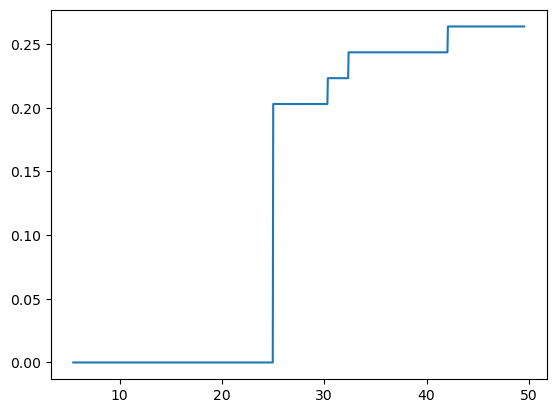

In [27]:
fig, ax = plt.subplots(1, 1)
ax.plot(x, allocations)

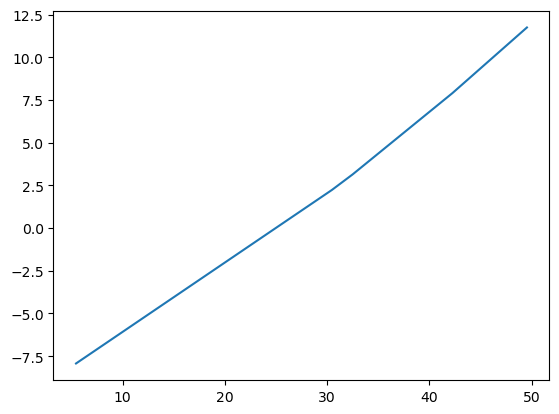

In [28]:
fig, ax = plt.subplots(1, 1)
ax.plot(x, generalized_virtual)

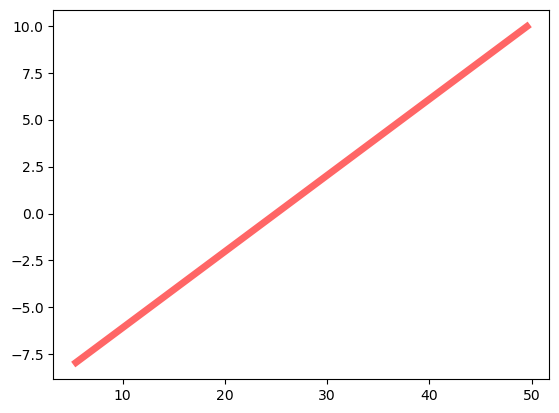

In [29]:
fig, ax = plt.subplots(1, 1)
ax.plot(x, ctr * y, 'r-', lw = 5, alpha = 0.6)